In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from skimage.transform import resize
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.utils import to_categorical
import cv2
import keras
import time

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
base_dir = 'C:\\Users\\0___0\\Dropbox\\Xray_data\\'
train_dir = base_dir + 'train\\'
test_dir = base_dir + 'test\\'

norm_train = glob.glob(train_dir + 'NORMAL\\*')
pne_train = glob.glob(train_dir + 'PNEUMONIA\\*')
cov_train = glob.glob(train_dir + 'COVID19\\*')

norm_test = glob.glob(test_dir + 'NORMAL\\*')
pne_test = glob.glob(test_dir + 'PNEUMONIA\\*')
cov_test = glob.glob(test_dir + 'COVID19\\*')

train_lists = [norm_train, pne_train, cov_train]
test_lists = [norm_test, pne_test, cov_test]

# 1. EDA(Exploratory Data Analysis) 

### 데이터 별(Train/Test와 Normal/Pneumonia/Covid19) 이미지 크기, 분포, Pixel 히스토그램

In [3]:
def plot_eda1(col=4, figsize=(25, 15)):
    
    np.random.seed()
    
    pic_list1 = [norm_train[i] for i in np.random.randint(0, len(norm_train), col)]
    pic_list2 = [pne_train[i] for i in np.random.randint(0, len(pne_train), col)]
    pic_list3 = [cov_train[i] for i in np.random.randint(0, len(cov_test), col)]
    pic_list = pic_list1 + pic_list2 + pic_list3
    
    fig = plt.figure(figsize=figsize)
    for i, img in enumerate(pic_list):
        fig.add_subplot(3, col, i+1)
        imgs = mpimg.imread(img)
        if i<col:
            plt.title("Normal, size={0}".format(imgs.shape), fontsize=19)
        elif i<2*col:
            plt.title("Pneumonia, size={0}".format(imgs.shape), fontsize=19)
        else:
            plt.title("Covid19, size={0}".format(imgs.shape), fontsize=19)
        plt.imshow(imgs)
        plt.axis('off')
    plt.show()

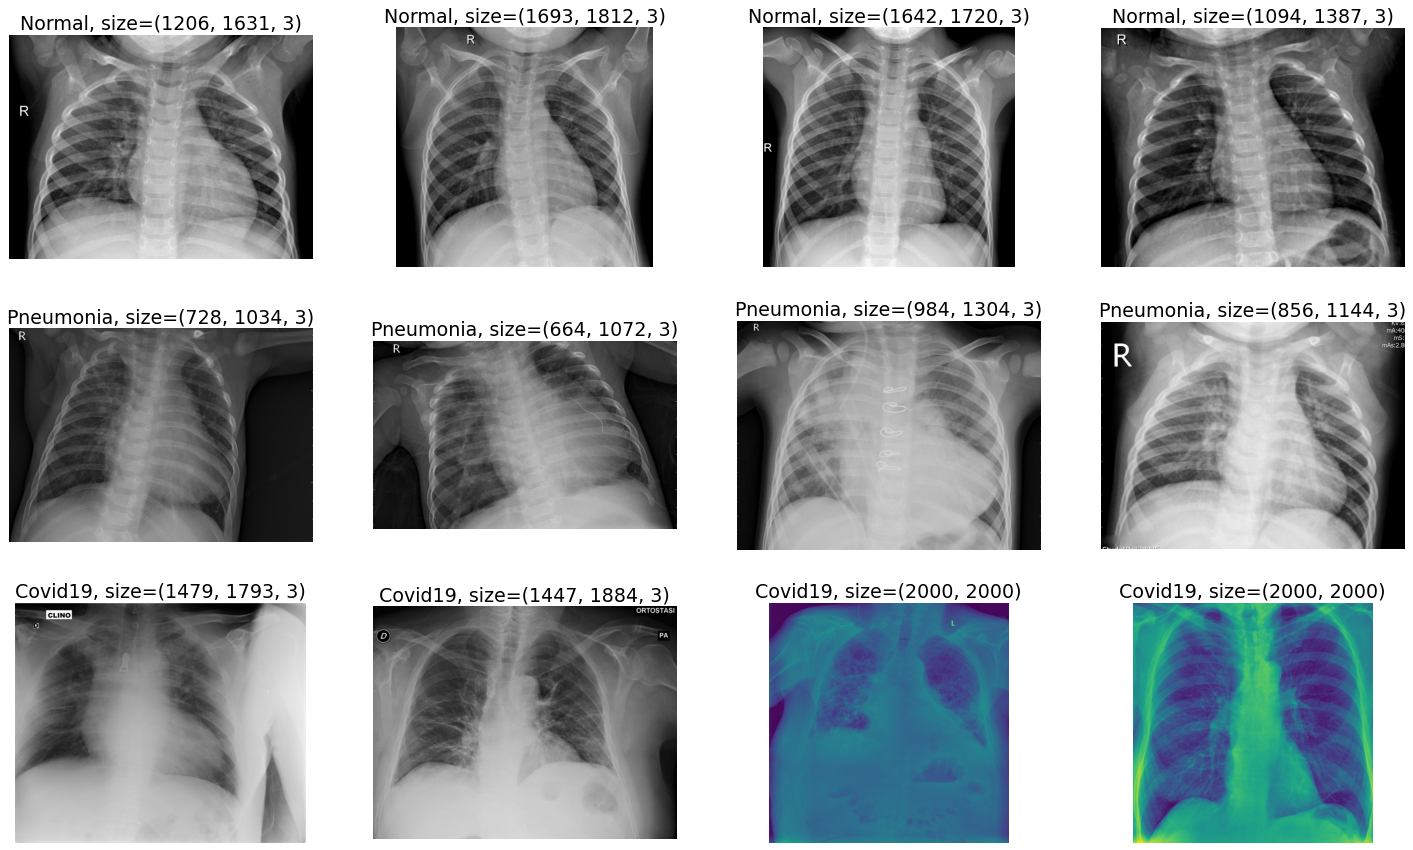

In [4]:
plot_eda1()

In [5]:
def plot_eda2(train_lens, test_lens, figsize=(25, 15)):
    
    set_sum = {}
    set_sum['Train'] = train_lens
    set_sum['Test'] = test_lens
    
    df_sum = pd.DataFrame(set_sum, index=['Normal', 'Pneumonia', 'Covid19'])
    
    plt.style.use(['default'])
    plt.figure(figsize=figsize, facecolor='white')
    ax = df_sum.T.plot(kind='bar', rot=0, color=sns.color_palette('Blues')[1:])
    
    for p in ax.patches:
        left, bottom, width, height = p.get_bbox().bounds
        ax.annotate("%d"%(height), (left+width/2, height+50), ha='center', fontsize=11)
    
    plt.title('Size of Data', fontsize=16)
    plt.ylim([0, 4000])
    plt.tick_params(axis='x', labelsize=14)
    plt.grid(False)
    plt.axis('off')
    plt.show()

<Figure size 1600x1200 with 0 Axes>

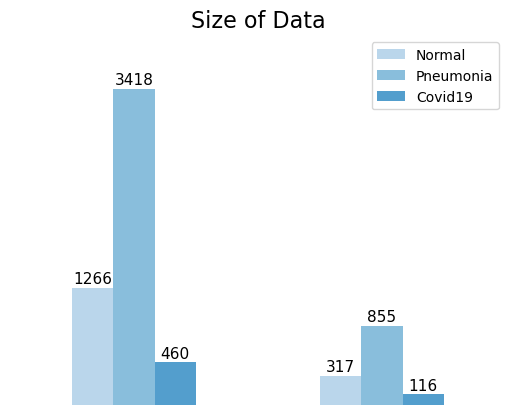

In [6]:
train_len_before = [len(i) for i in train_lists]
test_len_before = [len(i) for i in test_lists]
plot_eda2(train_len_before, test_len_before, (16, 12))

In [7]:
def plot_eda3():
    sp_list = [0, 6]
    for i in sp_list:
        plt.style.use(['default'])
        imgs = cv2.imread(str(norm_train[i]))
        imgs = cv2.resize(imgs, (512, 512))
        fig = plt.figure(figsize=(12, 4), facecolor='white')
        fig.add_subplot(1, 2, 1)
        plt.imshow(imgs)
        plt.axis(False)
        plt.title('Sample image', fontsize=16)
        ax = fig.add_subplot(1, 2, 2)
        hist = cv2.calcHist([imgs], [0], None, [256], [0,256])
        plt.plot(hist, color=sns.color_palette('Pastel1')[1])
        plt.fill_between(range(256), [0]*256, [int(num) for num in hist], color=sns.color_palette('Blues')[0])
        plt.title('Histogram for Pixel of Sample image', fontsize=16)
        plt.xlabel('Pixel Value')
        ax.axes.yaxis.set_ticks([])
        ax.axes.xaxis.set_ticks([])
        plt.ylabel('# of Pixel')
        plt.grid(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        plt.show()

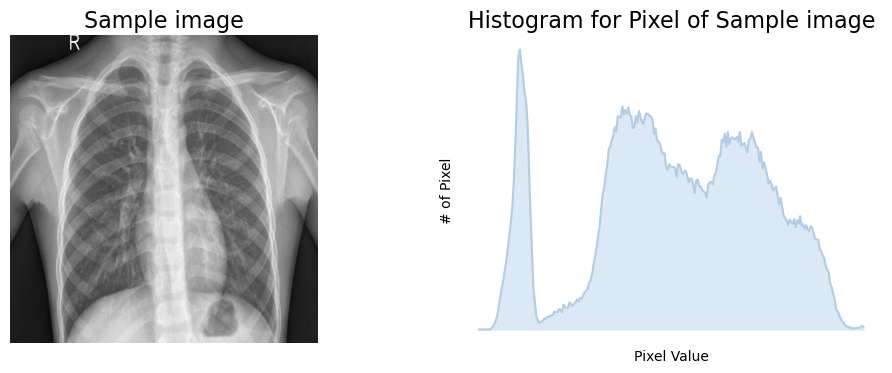

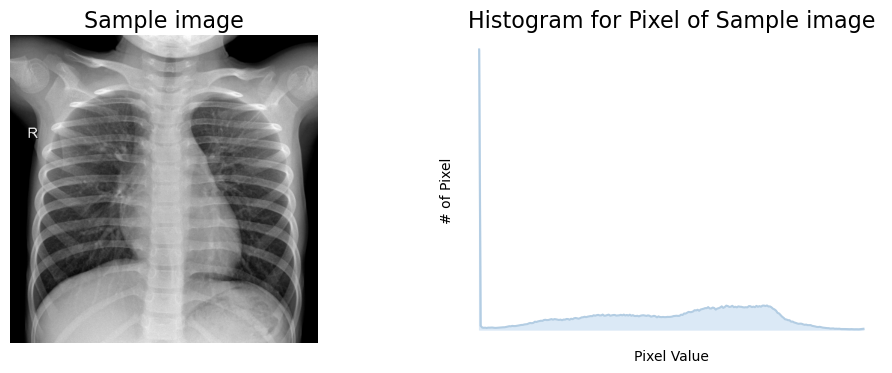

In [8]:
plot_eda3()

# 2. Preprocessing

### Data augmentation을 통한 Oversampling & Histogram Equalization

In [9]:
def plot_preprocessing1(num):
    
    sp_num = 22    
    datagen = ImageDataGenerator(rotation_range = 20,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=False,
                                     vertical_flip=False,
                                     fill_mode='nearest')
    img = cv2.imread(str(cov_train[sp_num]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.

    case_data_arr = np.array([img])
    it = datagen.flow(case_data_arr)
    
    plt.style.use(['default'])
    plt.figure(figsize=(8,3))
    plt.imshow(case_data_arr[0])
    plt.title('Original image', fontsize=16)
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
    plt.show()

    fig = plt.figure(figsize=(8, 5))
    for j in range(num):
        fig.add_subplot(3, 4, j+1)
        batch=it.next()
        img = batch[0]
        plt.axis(False)
        plt.imshow(img)
    plt.show()

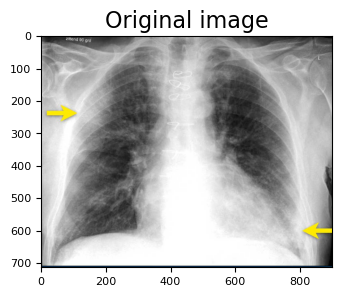

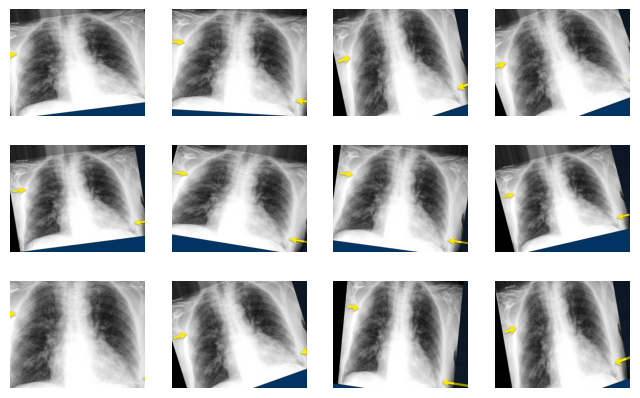

In [10]:
plot_preprocessing1(12)

In [11]:
def plot_preprocessing2():
    
    sp_list = [0, 6]
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
    for i in sp_list:
        if i < 3:
            img33 = cv2.imread(str(norm_train[i]), 0)
        else:
            img33 = cv2.imread(str(pne_train[i]), 0)
        equ = clahe.apply(img33)
        hist1 = cv2.calcHist([img33], [0], None, [256], [0,256])
        hist2 = cv2.calcHist([equ], [0], None, [256], [0,256])

        plt.style.use(['default'])
        fig = plt.figure(figsize=(9, 4))
        fig.add_subplot(1, 2, 1)
        img33 = np.stack([img33, img33, img33], axis=2)
        plt.imshow(img33)
        plt.title('Before Histogram Equalization', fontsize=14)
        plt.xticks(fontsize = 8)
        plt.yticks(fontsize = 8)

        fig.add_subplot(1, 2, 2)
        equ = np.stack([equ, equ, equ], axis=2)
        plt.imshow(equ)
        plt.title('After Histogram Equalization', fontsize=14)
        plt.xticks(fontsize = 8)
        plt.yticks(fontsize = 8)
        plt.show()

        fig = plt.figure(figsize=(9, 4))
        ax = fig.subplots()
        plt.style.use(['default'])
        plt.title('Histogram for pixels Before & After Equalization', fontsize=17)
        plt.xticks(fontsize = 8)
        plt.yticks(fontsize = 8)
        plt.plot(hist1, label='before', color=sns.color_palette('Pastel1')[1])
        plt.fill_between(range(256), [0]*256, [int(num) for num in hist1], color=sns.color_palette('Blues')[0])
        plt.plot(hist2, label='after', color=sns.color_palette('Pastel1')[6])
        plt.fill_between(range(256), [0]*256, [int(num) for num in hist2], color=sns.color_palette('Pastel1')[4])
        plt.xlabel('Pixel Value')
        ax.axes.yaxis.set_ticks([])
        ax.axes.xaxis.set_ticks([])
        #ax.axes.yaxis.set_visible(False)
        plt.ylabel('# of Pixel')
        plt.legend(loc='best')
        plt.grid(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        
        plt.show

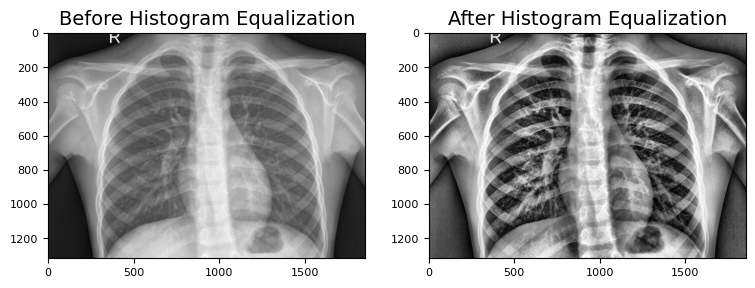

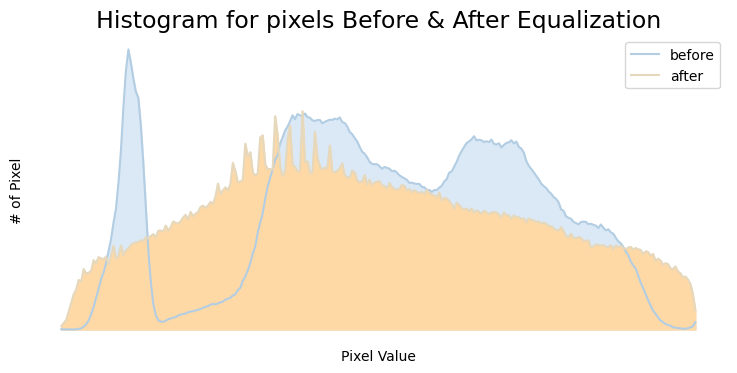

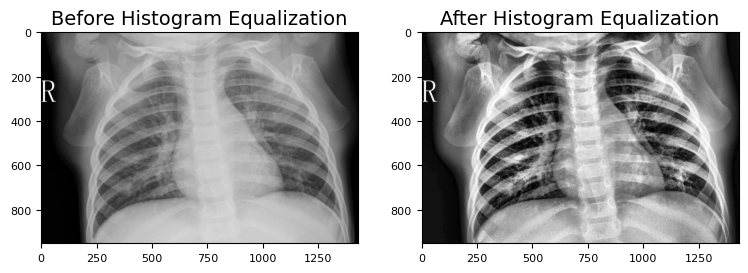

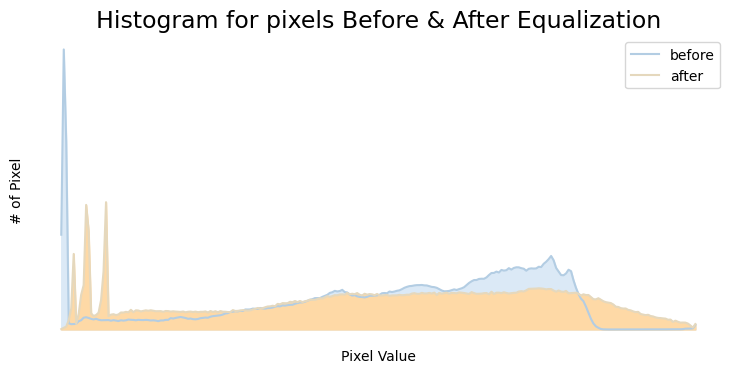

In [12]:
plot_preprocessing2()

In [13]:
def aug_oversampling(case, n, case_class, img_size=(128, 128)):
    
    case_data = []
    case_labels = []
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
    for img in case:
        img = cv2.imread(str(img), 0)
        img = cv2.resize(img, img_size)
        img = clahe.apply(img)
        img = img.astype(np.float32)/255.
        img = np.stack([img, img, img], axis=2)
        case_data.append(img)
        
    case_data_arr = np.array(case_data)
    
    datagen = ImageDataGenerator(rotation_range = 15,
                                 shear_range=0.1,
                                 zoom_range=0.2,
                                 horizontal_flip=False,
                                 vertical_flip=False,
                                 fill_mode='nearest')
    
    it = datagen.flow(case_data_arr)
    
    for repeat in range(n):
        label = keras.utils.to_categorical(case_class, num_classes=3)
        case_labels.append(label)

    if n >= len(case):
        for j in range(n - len(case)):
            batch=it.next()
            img = batch[0]
            case_data.append(img)
        return np.array(case_data), np.array(case_labels)

    else:
        print('It is NOT oversampling')
        return np.array(case_data[:n]), np.array(case_labels[:n])
    
def plot_data(data, n):
    i = 0
    for img in data:
        i += 1
        plt.imshow(img)
        plt.show()
        if i == n:
            break
            
def shuffle_data(data1, data2, data3, data_label1, data_label2, data_label3):
    
    data = np.concatenate([data1, data2, data3], axis=0)
    data_label = np.concatenate([data_label1, data_label2, data_label3], axis=0)
    
    idx = np.arange(data.shape[0])
    np.random.shuffle(idx)
    
    shuffled_data = data[idx]
    shuffled_data_label = data_label[idx]
    
    idx1 = np.where(idx==0)[0][0]
    idx2 = np.where(idx==len(data1))[0][0]
    idx3 = np.where(idx==len(data1)+len(data2))[0][0]
    
    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)
    ax1.set_title('CHECK! - norm_first')
    ax2.set_title('CHECK! - pne_first')
    ax3.set_title('CHECK! - cov_first')
    ax1.imshow(shuffled_data[idx1])
    ax2.imshow(shuffled_data[idx2])
    ax3.imshow(shuffled_data[idx3])
    plt.show()
    
    return shuffled_data, shuffled_data_label

def data_aug(size):
    start = time.time()

    norm_data, norm_label = aug_oversampling(norm_train, 3500, 0, size)
    pne_data, pne_label = aug_oversampling(pne_train, 3500, 1, size)
    cov_data, cov_label = aug_oversampling(cov_train, 3500, 2, size)

    train_data, train_label = shuffle_data(norm_data, pne_data, cov_data,
                                           norm_label, pne_label, cov_label)

    norm_data_test, norm_label_test = aug_oversampling(norm_test, len(norm_test), 0, size)
    pne_data_test, pne_label_test = aug_oversampling(pne_test, len(pne_test), 1, size)
    cov_data_test, cov_label_test = aug_oversampling(cov_test, len(cov_test), 2, size)

    test_data, test_label = shuffle_data(norm_data_test, pne_data_test, cov_data_test,
                                         norm_label_test, pne_label_test, cov_label_test)

    print("Data aumentation time for test set : {0:.2f}s".format(time.time() - start))
    
    #np.save('train_data{0}'.format(size[0]), train_data)
    #np.save('train_label{0}'.format(size[0]), train_label)
    #np.save('test_data{0}'.format(size[0]), test_data)
    #np.save('test_label{0}'.format(size[0]), test_label)
    
    return [len(norm_data), len(pne_data), len(cov_data)], [len(norm_data_test), len(pne_data_test), len(cov_data_test)]

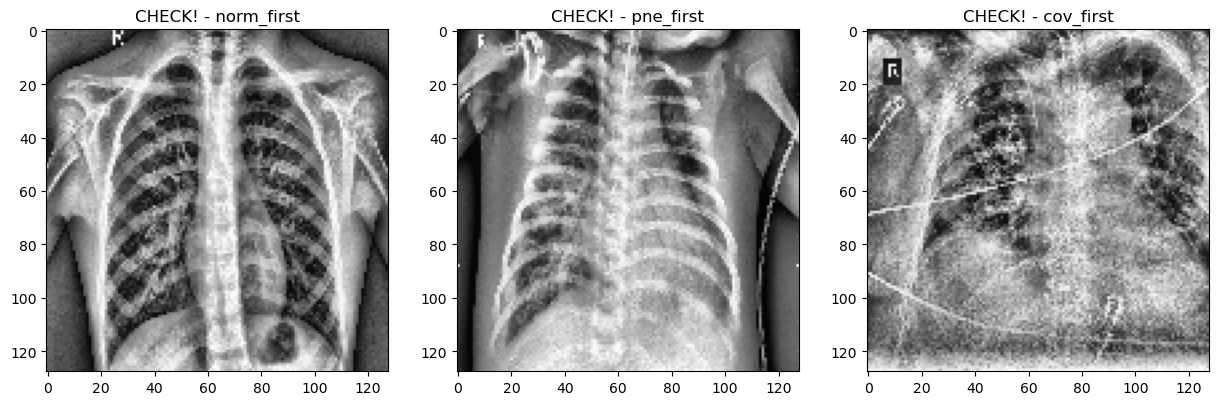

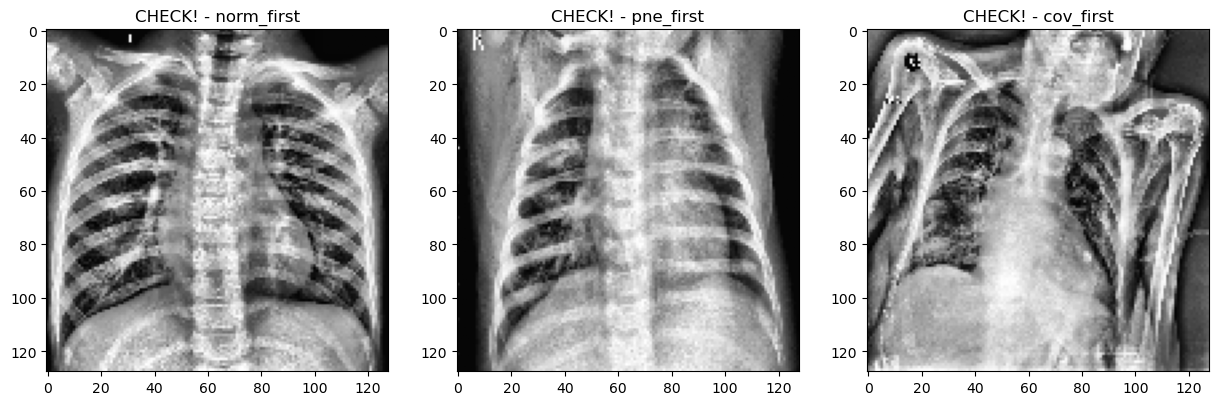

Data aumentation time for test set : 379.95s


In [14]:
train_len_after, test_len_after = data_aug((128, 128))

<Figure size 1600x1200 with 0 Axes>

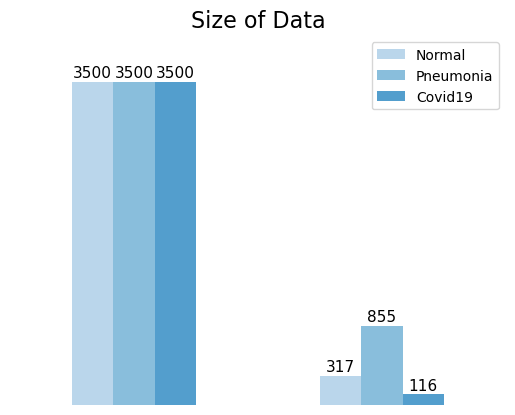

In [15]:
plot_eda2(train_len_after, test_len_after, (16, 12))